<a href="https://colab.research.google.com/github/shaonannan/2PopJagger/blob/master/EI_recurrent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pylab as plt
from numpy import linalg as la
from scipy.optimize import fsolve

In [3]:
# theoretical solution for kappa
kappa = np.arange(-5.0,5.0,0.1)

def F_kappa(JE=5.0,JI=1.0,I1=2.0,I2=1.0):
  # calculate stm's projection to m
  amp_m = 1.0/np.sqrt(2)
  m = np.ones((2,1))
  innermul = I1*m[0,0] +I2*m[1,0]
  I_org = np.ones((2,1))
  I_org[0,0],I_org[1,0] = I1,I2
  amp_I2m = innermul/np.sqrt(np.sum(m**2))
  I_overlap=amp_I2m*amp_m
  I_proj = amp_I2m*amp_m*m
  I_perpen = I_org-I_proj

  eterm=JE*(1+np.tanh(kappa+I_perpen[0,0]))/2.0
  iterm=JI*(1+np.tanh(kappa+I_perpen[1,0]))/2.0
  g_x  =eterm-iterm+I_overlap
  plt.figure(1)
  plt.plot(kappa,kappa,'--')
  plt.plot(kappa,g_x,'r')
_ = widgets.interact(F_kappa,JE=(0.0,6.0,.1),
                     JI=(0.0,6.0,.1),I1=(-6.0,6.0,.1),I2=(-6.0,6.0,.1))

interactive(children=(FloatSlider(value=5.0, description='JE', max=6.0), FloatSlider(value=1.0, description='J…

Variables and Parameters
* To find the Fixed Points is like figure out the intersections of two curves
  $f\kappa)=\kappa$ and $g(\kappa)=J_E(1+\mathrm{tanh}(\kappa+I_{\perp}^E))/2-J_I(1+\mathrm{tanh}(\kappa+I_{\perp}^I))/2+\mathcal{O}_{mI}$

Basic Functions
* nonlinear transfer Functions
* iterative loops
* finding roots
* etc.

In [8]:
# nonlinear transfer function -- we use tanh
def nonlineartransfer(x,params,type='tanh'):
    if type=='relu':
        a,theta = params[0],params[1]
        if x-theta>0:
            return a*(x-theta)
        else:
            return 0
    elif type=='tanh':
        return (1.0+np.tanh(x))/2.0

# run iterative loops, each one has a set of parameters
def run_dynamics(x0, stm, Net_settings,Conn_mat):
    tf_type = Net_settings['transfer_func']
    JE,JI   = Conn_mat['JE'],Conn_mat['JI']
    tfinal  = Net_settings['final_time']
    dt      = Net_settings['time_step']
    taxis = np.arange(0,tfinal,dt)
    nnum,nt = len(x0),len(taxis)
    x_seq = np.zeros((nnum,nt))
    x_dot_seq = np.zeros_like(x_seq)
    x_seq[:,0] = x0[:,0]
    for idxt in range(1,nt):
        for idx in range(nnum):
            x_dot = -x_seq[idx,idxt-1]+JE*nonlineartransfer(x_seq[0,idxt-1],0,)-JI*nonlineartransfer(x_seq[1,idxt-1],0,)+stm[idx]
            x_seq[idx,idxt]=x_dot*dt+x_seq[idx,idxt-1]
            x_dot_seq[idx,idxt-1] = x_dot

    return taxis,x_seq,x_dot_seq

# theoretical solution, finding roots 
def func_kappa(x,params):
    JE,JI,I1,I2,I_overlap,m=params[0],params[1],params[2],params[3],params[4],params[5]  
    return -x+(JE-JI)/2.0+(JE*np.tanh(x+I1)-JI*np.tanh(x+I2))/2.0+I_overlap

# r.h.s. function g(\kappa)
def rhsg_kappa(x,params):
    JE,JI,I1,I2,I_overlap,m = params[0],params[1],params[2],params[3],params[4],params[5]
    return JE*(1+np.tanh(x+I1))/2.0-JI*(1+np.tanh(x+I2))/2.0+I_overlap
# decompose the input signal I_{ext} -- component parallel to m and perpendicular to m
def decompinput(Iorg,m,):
  I1,I2=Iorg[0,0],Iorg[1,0]
  # overlapping
  innermul = I1*m[0,0]+I2*m[1,0]
  amp_m = 1.0/np.sqrt(np.sum(m**2))
  amp_I2m = innermul/np.sqrt(np.sum(m**2))
  I_overlap=amp_I2M*amp_m
  I_proj = amp_I2m*amp_m*m
  I_perpen = Iorg-I_proj
  
  return I_overlap,I_proj,I_perpen

# figure out the critical points, which meet the requirement -- f(x) is tangent to g(x)
def solvetangent(x,params):
    x0,x1=x.tolist()
    JE,JI,I1,I2=params[0],params[1],params[2],params[3]
    C=(JE-JI)/2.0
    return [-x0+JE*(1+np.tanh(x0+I1))/2.0-JI*(1+np.tanh(x0+I2))/2.0+x1,-1+JE*(1-(np.tanh(x0+I1))**2)/2.0-JI*(1-(np.tanh(x0+I2))**2)/2.0]


the low one: 0.8813735870194974 -2.53283997535363
the top one: -0.8813735870285958 -1.4671600246617105


Initiating the Network, giving parameters and hyper-parameters
* Network settings: dt, tfinal, type of transfer function
* connectivity matrix 
* etc

In [10]:
# Network settings
Net_settings ={'transfer_func': 'tanh',
                'time_step': 0.1,
                'final_time':150,
}
# connectivity matrix
Conn_mat ={'JE': 5.0,
            'JI':1.0,
}
m = np.ones((2,1))
ntt = int(Net_settings['final_time']/Net_settings['time_step'])

**Simple case**   
Here we further simplify our network model, define a new parameter $C=\frac{J_E-J_I}{2}$, and let $I=I_E=I_I$. In this simple case, the network dynamics is controlled by parameter $C$ and amplitude of external input $I\left(I_{amp}\right)$.  
* First, we ***fix $C$*** and continuously ***change $I_{amp}$***, numerically figure out the dynamics of $x$. 

In [13]:
JE,JI = Conn_mat['JE'],Conn_mat['JI']
tf, dt = Net_settings['final_time'],Net_settings['time_step']
tt = np.arange(0.0,Net_settings['final_time'],Net_settings['time_step'])

# choose 3 typical points to do numerical simulation
Iamp_typical = np.array([-3.0,-2.530,-2.0,-1.467,-1.0])
nparam_Iamp = len(Iamp_typical)
kappa_num_series_up,kappa_num_series_bot = np.zeros((nparam_Iamp,ntt)),np.zeros((nparam_Iamp,ntt))
x_dot_series_up,x_dot_series_bot = np.zeros((nparam_Iamp,2,ntt)),np.zeros((nparam_Iamp,2,ntt))
x_series_up,x_series_bot = np.zeros((nparam_Iamp,2,ntt)),np.zeros((nparam_Iamp,2,ntt))
eps = 0.1
for idxi in np.arange(nparam_Iamp):
    C= (JE-JI)/2.0
    stm = Iamp_typical[idxi]*np.ones((2,1))
    # upper approximate
    x0 = 2*C*np.ones((2,1))
    taxis, x_seq,x_dot_seq = run_dynamics(x0, stm, Net_settings,Conn_mat)
    x_series_up[idxi,:,:], x_dot_series_up[idxi,:,:] = x_seq, x_dot_seq
    kappa_num_series_up[idxi,:] = x_series_up[idxi,0,:]#-stm[0,0]
    # bottom approximate
    x0 = -2*C*np.ones((2,1))
    taxis, x_seq,x_dot_seq = run_dynamics(x0, stm, Net_settings,Conn_mat)
    x_series_bot[idxi,:,:], x_dot_series_bot[idxi,:,:] = x_seq, x_dot_seq
    kappa_num_series_bot[idxi,:] = x_series_bot[idxi,0,:]#-stm[0,0]

Visualize the temporal responses of $x$ under different $I_{amp}$



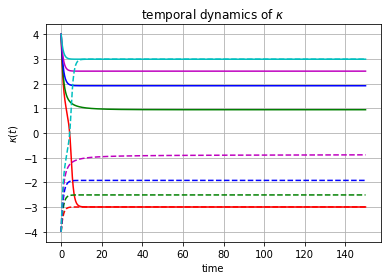

In [14]:
# # temporal dynamics of X and also \kappa
# plt.figure()
# plt.plot(tt,x_series_up[0,0,:],'r',label=r"$J_E=0.5$ upper")
# plt.plot(tt,x_series_up[1,0,:],'k',label=r"$J_E=3.0$ upper")
# plt.plot(tt,x_series_up[2,0,:],'b',label=r"$J_E=5.0$ upper")
# plt.plot(tt,x_series_bot[0,0,:],'--r',label=r"$J_E=0.5$ bottom")
# plt.plot(tt,x_series_bot[1,0,:],'--k',label=r"$J_E=3.0$ bottom")
# plt.plot(tt,x_series_bot[2,0,:],'--b',label=r"$J_E=5.0$ bottom")
# plt.xlabel(r"time")
# plt.ylabel(r"$x(t)$")
# plt.legend()
# plt.grid()
# temporal dynamics of X and also \kappa
plt.figure()
plt.plot(tt,kappa_num_series_up[0,:],'r',label=r"$I_{amp}=-3.0$ upper")
plt.plot(tt,kappa_num_series_up[1,:],'g',label=r"$I_{amp}=-2.5$ upper")
plt.plot(tt,kappa_num_series_up[2,:],'b',label=r"$I_{amp}=-2.0$ upper")
plt.plot(tt,kappa_num_series_up[3,:],'m',label=r"$I_{amp}=-1.4$ upper")
plt.plot(tt,kappa_num_series_up[4,:],'c',label=r"$I_{amp}=-1.0$ upper")

plt.plot(tt,kappa_num_series_bot[0,:],'--r',label=r"$I_{amp}=-3.0$ bottom")
plt.plot(tt,kappa_num_series_bot[1,:],'--g',label=r"$I_{amp}=-2.5$ bottom")
plt.plot(tt,kappa_num_series_bot[2,:],'--b',label=r"$I_{amp}=-2.0$ bottom")
plt.plot(tt,kappa_num_series_bot[3,:],'--m',label=r"$I_{amp}=-1.4$ bottom")
plt.plot(tt,kappa_num_series_bot[4,:],'--c',label=r"$I_{amp}=-1.0$ bottom")
plt.xlabel(r"time")
plt.ylabel(r"$\kappa(t)$")
plt.title(r"temporal dynamics of $\kappa$")
# plt.legend()
plt.grid()

find the intersections of two curve $f(\kappa)=\kappa$ and $g(\kappa)=\frac{J_E-J_I}{2}(1+\mathrm{tanh}(\kappa))+\mathcal{O}_{mI}$, $x$-axis of the points are the 1D FP

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


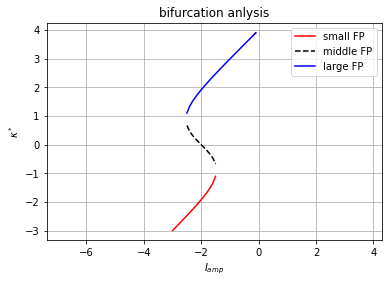

In [15]:
# parameters
JE,JI = 5.0,1.0
Iamp_series = np.arange(-3.0,0.0,0.1)
nparam_theoi = len(Iamp_series)
kappa_nsolve=np.zeros((nparam_theoi,3))
tolv = 1e-3
for idxi in np.arange(nparam_theoi):
    C=(JE-JI)/2.0
    # calculate stm's projection to m
    amp_m = 1.0/np.sqrt(2)   
    innermul = Iamp_series[idxi]*m[0,0] +Iamp_series[idxi]*m[1,0]
    I_org = Iamp_series[idxi]*np.ones((2,1))
    # I_org[0,0],I_org[1,0] = I1,I2
    amp_I2m = innermul/np.sqrt(np.sum(m**2))
    I_overlap=amp_I2m*amp_m
    I_proj = amp_I2m*amp_m*m
    I_perpen = I_org-I_proj
    kappaini=np.array([-2*C, -0.0, 2*C])
    for idxkappa in range(3):
        kappa_ = fsolve(func_kappa,[kappaini[idxkappa]],args=[JE,JI,I_perpen[0,0],I_perpen[1,0],I_overlap,m])
        # check the FP
        errv=func_kappa(kappa_,[JE,JI,I_perpen[0,0],I_perpen[1,0],I_overlap,m])
        if np.fabs(errv)<tolv:
          kappa_nsolve[idxi,idxkappa] = kappa_
        else:
          kappa_nsolve[idxi,idxkappa] = None

plt.figure(3)
plt.plot(Iamp_series,kappa_nsolve[:nparam_theoi,0],'r',label='small FP')
plt.plot(Iamp_series,kappa_nsolve[:nparam_theoi,1],'--k',label='middle FP')
plt.plot(Iamp_series,kappa_nsolve[:nparam_theoi,2],'b',label='large FP')
plt.xlabel(r"$I_{amp}$")
plt.xlim(-3.0,-1.0)
plt.ylabel(r"$\kappa^*$")
plt.title('bifurcation anlysis')
plt.legend()
plt.axis('equal')
plt.grid()


In [ ]:
print(np.tanh(-1.5**2))

-0.9780261147388136


We can also visualize the shape of function $g(\kappa)$ under different $I_{amp}$ 

(-3.2950000000000004,
 3.195000000000006,
 -3.2993963167350584,
 3.2873226514362246)

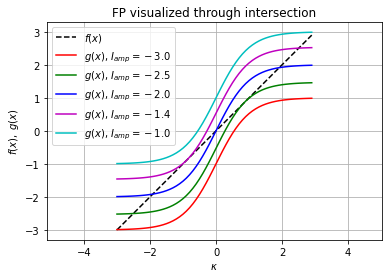

In [18]:
# Iamp_typical
kappa_set = np.arange(-3.0,3.0,0.1)
g_kappa_series = np.zeros((len(Iamp_typical),len(kappa_set)))
JE,JI=5.0,1.0
for idxi in range(len(Iamp_typical)):
    C = (JE-JI)/2.0
    # calculate stm's projection to m
    amp_m = 1.0/np.sqrt(2)   
    innermul = Iamp_typical[idxi]*m[0,0] +Iamp_typical[idxi]*m[1,0]
    I_org = Iamp_typical[idxi]*np.ones((2,1))
    # I_org[0,0],I_org[1,0] = I1,I2
    amp_I2m = innermul/np.sqrt(np.sum(m**2))
    I_overlap=amp_I2m*amp_m
    I_proj = amp_I2m*amp_m*m
    I_perpen = I_org-I_proj

    eterm = JE*(1+np.tanh(kappa_set+I_perpen[0,0]))/2.0
    iterm = JI*(1+np.tanh(kappa_set+I_perpen[1,0]))/2.0
    g_kappa_series[idxi,:] = eterm-iterm+I_overlap

# visualize the results
plt.figure()
plt.plot(kappa_set,kappa_set,'--k',label=r"$f(x)$")
plt.plot(kappa_set,g_kappa_series[0,:],'r',label=r"$g(x)$, $I_{amp}=-3.0$")
plt.plot(kappa_set,g_kappa_series[1,:],'g',label=r"$g(x)$, $I_{amp}=-2.5$")
plt.plot(kappa_set,g_kappa_series[2,:],'b',label=r"$g(x)$, $I_{amp}=-2.0$")
plt.plot(kappa_set,g_kappa_series[3,:],'m',label=r"$g(x)$, $I_{amp}=-1.4$")
plt.plot(kappa_set,g_kappa_series[4,:],'c',label=r"$g(x)$, $I_{amp}=-1.0$")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$f(x),\ g(x)$")
plt.title(r"FP visualized through intersection")
plt.legend()
plt.grid()
plt.axis('equal')
    

In conclusion, in this simplest case, there are two **Saddle-Node Bifurcation**s. We can figure out the Saddle-Node bifurcation by solving a set of (two) equations,
$$f(\kappa)=g(\kappa)$$
$$f'(\kappa)=g'(\kappa)$$




In [22]:
# find the saddle-node bifurcation points
tangp = np.zeros((2,2))
JE,JI=5,1
kappa0,i0=1.0,-3.0
x0,x1 = fsolve(solvetangent,[kappa0,i0],args=[JE,JI,0,0])
tangp[0,0],tangp[0,1]=x0,x1
print('the lower one: kappa --',x0,', Iamp --',x1)
kappa0,i0=-1.0,-1.6
x0_,x1_ = fsolve(solvetangent,[kappa0,i0],args=[JE,JI,0,0])
tangp[1,0],tangp[1,1]=x0_,x1_
print('the top one: kappa --',x0_,', Iamp --',x1_)

the lower one: kappa -- 0.8813735870194974 , Iamp -- -2.53283997535363
the top one: kappa -- -0.8813735870285958 , Iamp -- -1.4671600246617105


* Then, another way to view this question, we ***fix $I_{amp}$*** and continuously ***change $C$*** instead, numerically figure out the dynamics of $x$. 

Note that in the simple case with $I_{amp}=I_{\perp}^E=I_{\perp}^I$, the r.h.s. Eq is $g(\kappa)=C(1+\mathrm{tanh}(\kappa))+I_{amp}$, the first term always goes through the point $(0,C)$ and $I_{amp}=-C$ moves the curve to the center $(0,0)$. We analyze this special case.  
We set $I_{amp}=-C$, because $f'(\kappa)=1$ and $g'(0)=C$, $C=1$ is a special point where $f(\kappa)$ is tangent to $g(\kappa)$. So we change $C$ from 0 to 2.

(-3.2950000000000004,
 3.195000000000006,
 -3.2950000000000004,
 3.195000000000006)

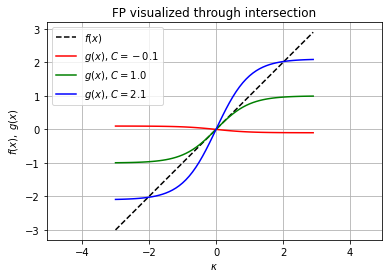

In [26]:
# C_typical
# fix JI and change JE--calculate C--configurate I_{amp}
je_typical = np.array([0.8,3.0,5.2])
kappa_set = np.arange(-3.0,3.0,0.1)
g_kappa_series = np.zeros((len(Iamp_typical),len(kappa_set)))
JI=1.0
for idxje in range(len(je_typical)):
    JE = je_typical[idxje]
    C = (JE-JI)/2.0
    Iamp=-C
    # calculate stm's projection to m
    amp_m = 1.0/np.sqrt(np.sum(m**2))   
    innermul = Iamp*m[0,0] +Iamp*m[1,0]
    I_org = Iamp*np.ones((2,1))
    # I_org[0,0],I_org[1,0] = I1,I2
    amp_I2m = innermul/np.sqrt(np.sum(m**2))
    I_overlap=amp_I2m*amp_m
    I_proj = amp_I2m*amp_m*m
    I_perpen = I_org-I_proj

    eterm = JE*(1+np.tanh(kappa_set+I_perpen[0,0]))/2.0
    iterm = JI*(1+np.tanh(kappa_set+I_perpen[1,0]))/2.0
    g_kappa_series[idxje,:] = eterm-iterm+I_overlap

# visualize the results
plt.figure()
plt.plot(kappa_set,kappa_set,'--k',label=r"$f(x)$")
plt.plot(kappa_set,g_kappa_series[0,:],'r',label=r"$g(x)$, $C=-0.1$")
plt.plot(kappa_set,g_kappa_series[1,:],'g',label=r"$g(x)$, $C=1.0$")
plt.plot(kappa_set,g_kappa_series[2,:],'b',label=r"$g(x)$, $C=2.1$")

plt.xlabel(r"$\kappa$")
plt.ylabel(r"$f(x),\ g(x)$")
plt.title(r"FP visualized through intersection")
plt.legend()
plt.grid()
plt.axis('equal')

There is a bifurcation at $C=1$, when $C$ increases from value less than 1 to greater than 1, $(0,0)$ changes from being the only one stable FP to one of the three FPs, but the unstable one. We can plot the bifurcation graph 'FPs v.s. C'

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


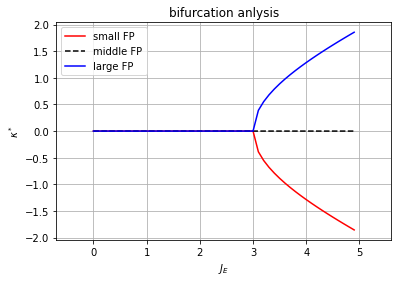

In [31]:
# parameters
JI = 1.0
je_series = np.arange(0.0,5.0,0.1)
nparam_theoje = len(je_series)
kappa_nsolve=np.zeros((nparam_theoje,3))
tolv = 1e-3
for idxje in np.arange(nparam_theoje):
    JE=je_series[idxje]
    C=(JE-JI)/2.0
    # calculate stm's projection to m
    amp_m = 1.0/np.sqrt(np.sum(m**2)) 
    Iamp = -C  
    innermul = Iamp*m[0,0] +Iamp*m[1,0]
    I_org = Iamp*np.ones((2,1))
    # I_org[0,0],I_org[1,0] = I1,I2
    amp_I2m = innermul/np.sqrt(np.sum(m**2))
    I_overlap=amp_I2m*amp_m
    I_proj = amp_I2m*amp_m*m
    I_perpen = I_org-I_proj
    kappaini=np.array([-C, 0.05, C])
    for idxkappa in range(3):
        kappa_ = fsolve(func_kappa,[kappaini[idxkappa]],args=[JE,JI,I_perpen[0,0],I_perpen[1,0],I_overlap,m])
        # check the FP
        errv=func_kappa(kappa_,[JE,JI,I_perpen[0,0],I_perpen[1,0],I_overlap,m])
        if np.fabs(errv)<tolv:
          kappa_nsolve[idxje,idxkappa] = kappa_
        else:
          kappa_nsolve[idxje,idxkappa] = None

plt.figure(3)
plt.plot(je_series,kappa_nsolve[:nparam_theoje,0],'r',label='small FP')
plt.plot(je_series,kappa_nsolve[:nparam_theoje,1],'--k',label='middle FP')
plt.plot(je_series,kappa_nsolve[:nparam_theoje,2],'b',label='large FP')
plt.xlabel(r"$J_E$")
plt.ylabel(r"$\kappa^*$")
plt.title('bifurcation anlysis')
plt.legend()
plt.axis('equal')
plt.grid()

A supercritical **Pitchfork Bifurcation** occurs when $J_E=3.0$ ($C=\frac{J_E-J_I}{2}=1$). Numerical simulation of variable $x(t)$ gives identical result 

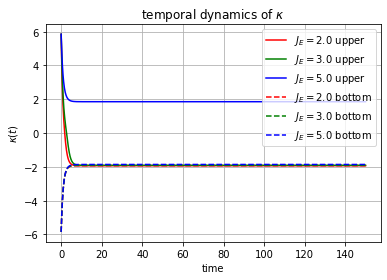

In [42]:
JE,JI = Conn_mat['JE'],Conn_mat['JI']
tf, dt = Net_settings['final_time'],Net_settings['time_step']
tt = np.arange(0.0,Net_settings['final_time'],Net_settings['time_step'])

# choose 3 typical points to do numerical simulation
kappa_num_series_up,kappa_num_series_bot = np.zeros((nparam_theoje,ntt)),np.zeros((nparam_theoje,ntt))
x_dot_series_up,x_dot_series_bot = np.zeros((nparam_theoje,2,ntt)),np.zeros((nparam_theoje,2,ntt))
x_series_up,x_series_bot = np.zeros((nparam_theoje,2,ntt)),np.zeros((nparam_theoje,2,ntt))
eps = 0.1
for idxje in np.arange(nparam_theoje):
    Conn_mat['JE']= je_series[idxje]
    C= (JE-JI)/2.0
    stm = -C*np.ones((2,1))
    # upper approximate
    x0 = 3*C*np.ones((2,1))
    taxis, x_seq,x_dot_seq = run_dynamics(x0, stm, Net_settings,Conn_mat)
    x_series_up[idxje,:,:], x_dot_series_up[idxje,:,:] = x_seq, x_dot_seq
    kappa_num_series_up[idxje,:] = x_series_up[idxje,0,:]#-stm[0,0]
    # bottom approximate
    x0 = -3*C*np.ones((2,1))
    taxis, x_seq,x_dot_seq = run_dynamics(x0, stm, Net_settings,Conn_mat)
    x_series_bot[idxje,:,:], x_dot_series_bot[idxje,:,:] = x_seq, x_dot_seq
    kappa_num_series_bot[idxje,:] = x_series_bot[idxje,0,:]#-stm[0,0]
plt.figure()
plt.plot(tt,kappa_num_series_up[20,:],'r',label=r"$J_E=2.0$ upper")
plt.plot(tt,kappa_num_series_up[30,:],'g',label=r"$J_E=3.0$ upper")
plt.plot(tt,kappa_num_series_up[49,:],'b',label=r"$J_E=5.0$ upper")

plt.plot(tt,kappa_num_series_bot[20,:],'--r',label=r"$J_E=2.0$ bottom")
plt.plot(tt,kappa_num_series_bot[30,:],'--g',label=r"$J_E=3.0$ bottom")
plt.plot(tt,kappa_num_series_bot[49,:],'--b',label=r"$J_E=5.0$ bottom")
plt.xlabel(r"time")
plt.ylabel(r"$\kappa(t)$")
plt.title(r"temporal dynamics of $\kappa$")
plt.legend()
plt.grid()

In conclusion, there are one supercritical **Pitchfork Bifurcation** in this network

**Different external inputs $I_{ext}$ for $\mathrm{E}$ and $\mathrm{I}$ neurons**  
(the vector $I_{\perp}\neq \mathbf{0}$)


In the previous case, input vector is parallel to the right sigular eigenvector of connectivity matrix $m^{(1)}$, so temporal dynamics of $\kappa$ only depends on (proportional to) the right eigenvector $m^{(1)}$ of recurrent subspace. ref to [Murphy and Miller Neuron 2009], In a more general case, external input vector $I_{ext}$ has component, which is perpendicular to recurrent vector $m^{(1)}$, can be expressed as $I_{\perp}$, also the projection of $I$ to $m$ can be expressed as the overlapping variable $\mathcal{O}_{mI}$.  
The response vector now is the linear combination of vector of recurrent subspace and stimulus subspace

$$x(t)=\kappa_{(1)}(t)m^{(1)}+\nu(t)I_{\perp}.$$  
According to Schmidt Normalization, we have
$$\mathcal{O}_{mI}= \frac{I^{\mathrm{T}}m}{\Vert m \Vert }\frac{1}{\Vert m \Vert},$$  
then the temporal dynamics of $\kappa,\ \nu$ is like  
$$\dot{\kappa}=-\kappa+\mathbf{n}^{\mathrm{T}}\phi(\kappa+\nu\mathbf{I}_{\perp})+\mathcal{O}_{mI}$$
$$\dot{\nu}=-\nu+1$$  
  

In [ ]:
# figure out the critical points, which meet the requirement -- f(x) is tangent to g(x)
def solvetangent(x,params):
    x0,x1=x.tolist()
    JE,JI=params[0],params[1]
    C=(JE-JI)/2.0
    return [-x0+C*(1+np.tanh(x0+x1)),-1+C*(1-(np.tanh(x0+x1))**2)]

# find the saddle-node bifurcation points
tangp = np.zeros((2,2))
JE,JI=5,1
kappa0,i0=-0.2,0.0
x0,x1 = fsolve(solvetangent,[kappa0,i0],args=[JE,JI])
tangp[0,0],tangp[0,1]=x0,x1
# print('the low one:',x0,x1)
kappa0,i0=2.0,-4.0
x0_,x1_ = fsolve(solvetangent,[kappa0,i0],args=[JE,JI])
tangp[1,0],tangp[1,1]=x0_,x1_
# print('the top one:',x0_,x1_)